# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components.

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, concatenate, Conv2DTranspose, ReLU, MaxPool2D, ZeroPadding2D, Dense, Flatten, Reshape, Dropout, UpSampling2D, InputLayer, Lambda
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import mixed_precision
import tensorflow.keras.backend as K
from tensorflow import keras
from keras import regularizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError

import cv2

import pandas as pd

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.


(60000, 28, 28)


In [ ]:
print(np.shape(mnist_x_train))
print(np.shape(mnist_y_train))

(60000, 32, 32)
(60000,)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)
        yield x_data, y_data

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [ ]:
batchsize = 64
inputShape = (32,32,1)

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,1)
validation_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

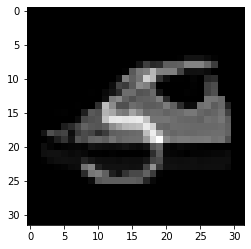

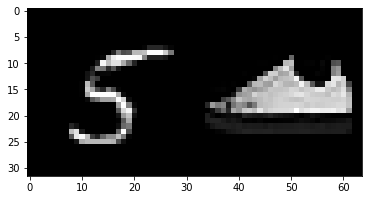

In [ ]:
x, y = next(train_generator)
plt.imshow(x[0], cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

# Building the dataset, test set and validation

In [ ]:
n_samples_train = 100000
n_samples_test = 20000
n_samples_val = 20000

In [ ]:
def create_sample(type):
    generator = train_generator
    if type==2:
        generator = test_generator
    if type==3:
        generator = validation_generator
    x, y = next(generator)
    return (x, y)

def create_dataset(x, y, type):
    x_actual = np.ndarray(inputShape)
    y_actual = np.ndarray((32,64,1))

    samples = n_samples_train
    if type==2:
        samples = n_samples_test
    if type==3:
        samples = n_samples_test

    for i in range(samples):
        x_actual, y_actual = create_sample(type)

        x_t = K.permute_dimensions(x_actual, (1,2,0))
        y_t = K.permute_dimensions(y_actual, (1,2,0))
        x[i]= x_t
        y[i] = y_t


In [ ]:
x_train = np.ndarray(shape=(n_samples_train, 32,32,1))
y_train = np.ndarray(shape=(n_samples_train, 32,64,1))
create_dataset(x_train, y_train, 1)

# Reduce the amount of memory needed during learning
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

print('Train shape:', x_train.shape)

print('Mean:', x_train.mean())
print('Std:', x_train.std())
print('Min:', x_train.min())
print('Max:', x_train.max())

Train shape: (100000, 32, 32, 1)
Mean: 0.15963276
Std: 0.24528311
Min: 0.0
Max: 1.0


In [ ]:
x_test = np.ndarray(shape=(n_samples_test, 32,32,1))
y_test = np.ndarray(shape=(n_samples_test, 32,64,1))
create_dataset(x_test, y_test, 2)


x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

print('Test shape: ', x_test.shape)

Test shape:  (20000, 32, 32, 1)


In [ ]:
x_val = np.ndarray(shape=(n_samples_val, 32,32,1))
y_val = np.ndarray(shape=(n_samples_val, 32,64,1))
create_dataset(x_val, y_val, 3)

x_val = x_val.astype('float32')
y_val = y_val.astype('float32')

print('Test shape: ', x_val.shape)

Test shape:  (20000, 32, 32, 1)


# Visualize the data

Exaples instances created for x_train (input): 


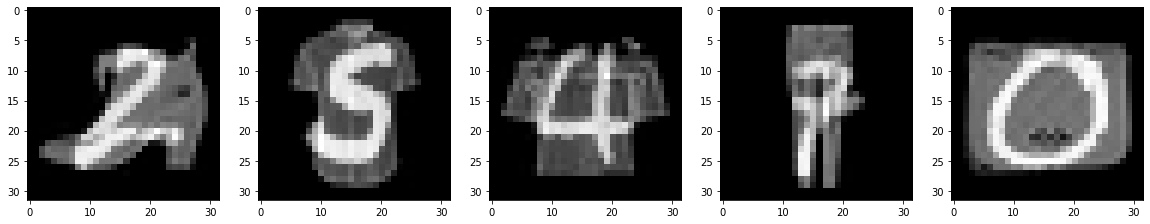

In [ ]:
print("Exaples instances created for x_train (input): ")

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,20))

for i in range(5):
    ax[i].imshow(x_train[i,:,:,0], cmap='gray', interpolation='nearest')

plt.show()

Exaples instances created for y_train (output): 


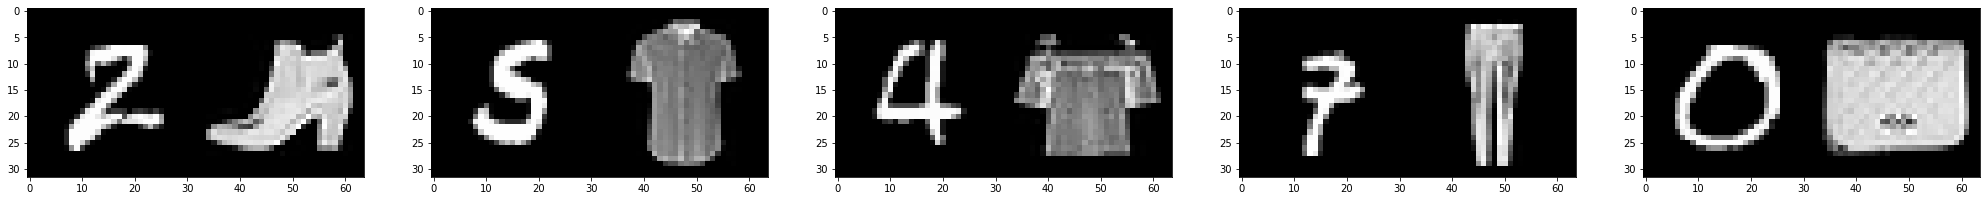

In [ ]:
print("Exaples instances created for y_train (output): ")

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(35,25))

for i in range(5):
    ax[i].imshow(y_train[i,:,:,0], cmap='gray', interpolation='nearest')

plt.show()

# Create the model and compile (CNN)

The reasons why the use of convolutional neural networks seems interesting are:
1. inputs and outputs of the problem are both images
2. CNN work well with images, the convolution is at the base of the process.
3. There are a lot of different architectures, but the foundamental operarion is always convolution.

Therefore the idea is to build a net which is able to extract local and global features from the input image in order to restore the original one.

#### UNet
The first architecture that came to my mind is Unet. It was designed for segmentation task, but I think it will reaches good performances also in this task.
The interesting thing that makes me think this is the fact that input and output of this model are images.

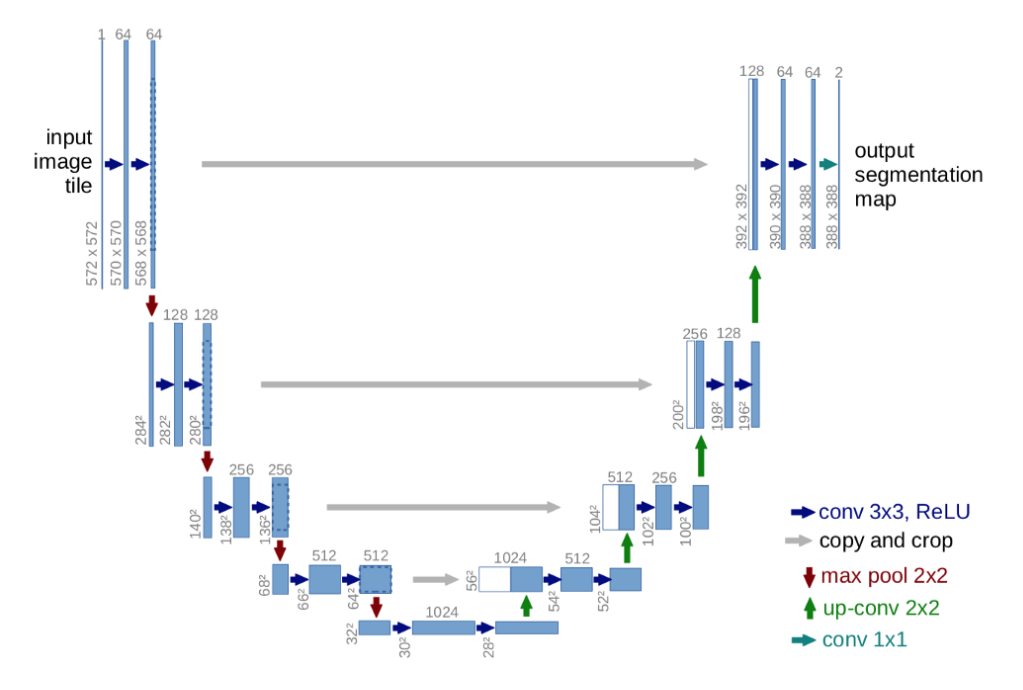

#### Input
A zeropadding layer has been added after the input layer in order to match input size with an only one output image, and not a concatenation of two outputs derived by different training or models.

##### Loss
Binary_crossentropy gives better results then others, so it has been chosen in accordance with some papers found online and some evidence given by computations with other loss functions.

### Define parameters for model

In [ ]:
lr = 1e-3

loss = 'binary_crossentropy'
optimizer = keras.optimizers.Adam(learning_rate=lr)
metric = ['mse']

In [ ]:
epochs = 10
batchsize = 64

In [ ]:
def create_model(inputShape, n_ch=32, L=5, conv_per_L=2):
    x = Input(shape=inputShape)

    pad_layer = ZeroPadding2D(padding=((0,0),(16,16)))(x)

    backup_layers = []
    h = pad_layer

    for l in range(L):
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1:
            # Downsample
            backup_layers.append(h)
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2

    for l in range(L-1):
        n_ch = n_ch // 2

        # Upsample
        h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

    # Output
    y = Conv2D(1, 1, activation='sigmoid')(h)
    return Model(x, y)

unet_model = create_model(inputShape)

unet_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metric)

print(unet_model.summary())

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 32, 64, 1)   0           ['input_21[0][0]']               
 D)                                                                                               
                                                                                                  
 conv2d_277 (Conv2D)            (None, 32, 64, 32)   320         ['zero_padding2d_4[0][0]']       
                                                                                                  
 re_lu_247 (ReLU)               (None, 32, 64, 32)   0           ['conv2d_277[0][0]']      

## Fitting the model

In [ ]:
history = unet_model.fit(x_train, y_train,
              batch_size=batchsize,
              epochs=epochs,
              validation_data=[x_val, y_val]
            )


Epoch 1/10
1563/1563 [==============================] - 54s 34ms/step - loss: 0.1622 - mse: 0.0155 - val_loss: 0.1361 - val_mse: 0.0065
Epoch 2/10
1563/1563 [==============================] - 52s 34ms/step - loss: 0.1327 - mse: 0.0057 - val_loss: 0.1332 - val_mse: 0.0055
Epoch 3/10
1563/1563 [==============================] - 52s 34ms/step - loss: 0.1293 - mse: 0.0046 - val_loss: 0.1294 - val_mse: 0.0043
Epoch 4/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.1274 - mse: 0.0040 - val_loss: 0.1286 - val_mse: 0.0040
Epoch 5/10
1563/1563 [==============================] - 52s 34ms/step - loss: 0.1261 - mse: 0.0036 - val_loss: 0.1268 - val_mse: 0.0035
Epoch 6/10
1563/1563 [==============================] - 52s 34ms/step - loss: 0.1252 - mse: 0.0033 - val_loss: 0.1266 - val_mse: 0.0034
Epoch 7/10
1563/1563 [==============================] - 52s 34ms/step - loss: 0.1245 - mse: 0.0031 - val_loss: 0.1261 - val_mse: 0.0033
Epoch 8/10
1563/1563 [==========================

In [ ]:
history.history

{'loss': [0.16224242746829987,
  0.1326555758714676,
  0.129265695810318,
  0.12743060290813446,
  0.12614843249320984,
  0.12522344291210175,
  0.12453160434961319,
  0.12402911484241486,
  0.12361278384923935,
  0.12325345724821091],
 'mse': [0.01547231525182724,
  0.005659108981490135,
  0.004580212756991386,
  0.003993140067905188,
  0.003581924829632044,
  0.0032839064951986074,
  0.0030625127255916595,
  0.002902576932683587,
  0.0027696944307535887,
  0.0026547296438366175],
 'val_loss': [0.13611826300621033,
  0.1331644356250763,
  0.12935125827789307,
  0.12859602272510529,
  0.12682324647903442,
  0.1265995055437088,
  0.12614212930202484,
  0.12539836764335632,
  0.12466097623109818,
  0.12439502030611038],
 'val_mse': [0.006458766758441925,
  0.005460857879370451,
  0.00429924251511693,
  0.004024467896670103,
  0.003481917083263397,
  0.003403882961720228,
  0.0032619498670101166,
  0.003021880052983761,
  0.002788625657558441,
  0.002703925594687462]}

#### Metrics

In [ ]:
def mse(y, y_pred):
    m = keras.metrics.MeanSquaredError()
    m.update_state(y, y_pred)
    return m.result().numpy()

### Evaluate the model

Testing mse on testset

In [ ]:
# Function that evaluate the model on a dataset

def evaluate_model(model, x, y, fun):
    y_pred = model.predict(x)
    y = np.expand_dims(y, -1)

    # Uniform the type of the array
    y_pred = y_pred.astype('float32')
    y = y.astype('float32')

    return fun(y, y_pred)

In [ ]:
MSE = evaluate_model(unet_model, x_test,  y_test, mse)
print(MSE)

0.002699472


In [ ]:
# compute the standard deviation over 10 mse
def standard_deviation_mse(model):
    MSE_results = []

    for i in range(10):
        x_test_local = np.ndarray(shape=(n_samples_test, 32,32,1))
        y_test_local = np.ndarray(shape=(n_samples_test, 32,64,1))
        create_dataset(x_test_local, y_test_local, 2)

        MSE_results.append(evaluate_model(model, x_test_local,  y_test_local, mse))

    std = np.std(MSE_results)

    return std, MSE_results

Standard deviation for current model:

In [ ]:
std, MSE_results = standard_deviation_mse(unet_model)
print("The std for Unet is: {}\n".format(std))
print("The mse results are: \n{}".format(MSE_results))

The std for Unet is: 1.3327326087164693e-05

The mse results are: 
[0.0026960094, 0.0027172612, 0.0027093452, 0.0027205718, 0.0026907404, 0.0027340583, 0.002702055, 0.0027083538, 0.002697955, 0.0027259816]


### Plotting a visual result

Plotting some example of predicted images

In [ ]:
def show(x, y, title=None):
    plt.figure(figsize=(5, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap='gray', interpolation='nearest')

    if title:
        plt.title(title[0])

    plt.subplot(1, 2, 2)
    plt.imshow(y, cmap='gray', interpolation='nearest')

    if title:
        plt.title(title[1])

    plt.show()

(1, 32, 64, 1)


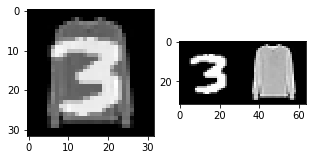

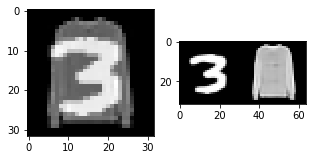

In [ ]:
# Qualitative results
y_pred = unet_model.predict(x_test[:1])
print(np.shape(y_pred))

show(x_test[0][:,:,0], y_test[0][:,:,0])
show(x_test[0][:,:,0], y_pred[0][:,:,0])

Sample number: 3741



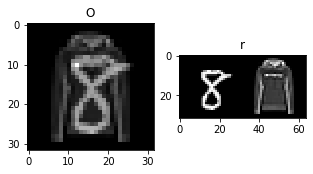

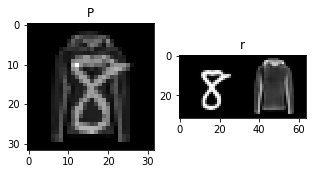



Sample number: 4955



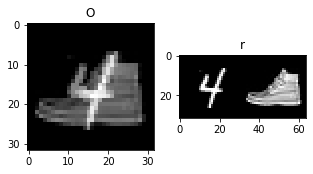

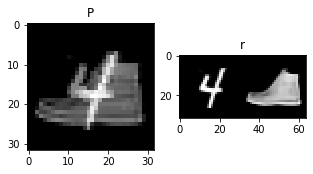



Sample number: 4216



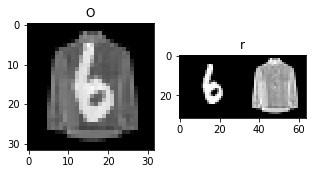

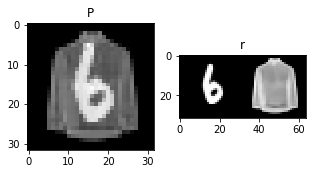

In [ ]:
# number of samples to print
tot = 3

for j in range(tot):
  # random sample number of test set
  i = np.random.randint(10000)
  print("Sample number: {}\n".format(i))

  x_test_n = x_test[i]
  (n,w,h) = x_test_n.shape
  x_test_n = x_test_n.reshape(1,n,w,h)

  y_pred_n = unet_model.predict(x_test_n)

  show(x_test[i][:,:,0], y_test[i][:,:,0], title='Original')
  show(x_test[i][:,:,0], y_pred_n[0][:,:,0], title='Predicted')

  print("\n")

### checking overfitting by plots

As we can see from the plot, also after 10 epochs, the validation results tend to follow a good behavior, so there aren't problems with overfitting. It seems right due to the fact that there are a lot of random samples wich are a subset of 60000*60000 possible combinations.

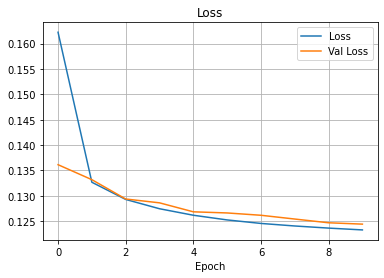

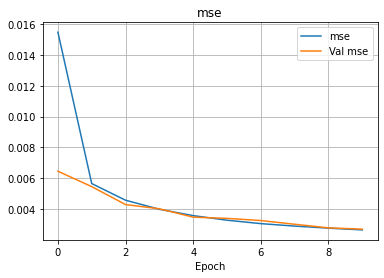

In [ ]:
# Check overfit
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

mse_history = history.history['mse']
val_mse_history = history.history['val_mse']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(mse_history)
plt.plot(val_mse_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mse', 'Val mse'])
plt.title('mse')
plt.show()

### Checking robustness adding gaussian noise to a testset

In [ ]:
from skimage.util import random_noise

def add_noise(img):
    gauss = random_noise(img, mode='gaussian', clip=True)
    # sp = random_noise(img,mode='s&p',seed=None,clip=True)
    # pepper = random_noise(img,mode='pepper',seed=None,clip=True)
    # speckle = random_noise(img,mode='speckle',seed=None,clip=True)

    return gauss

#### create a 20000 samples test set

In [ ]:
x_test_rob = np.ndarray(shape=(n_samples_test, 32,32,1))
y_test_rob = np.ndarray(shape=(n_samples_test, 32,64,1))
create_dataset(x_test_rob, y_test_rob, 2)

Add noise to the testset

example of image with noise: 



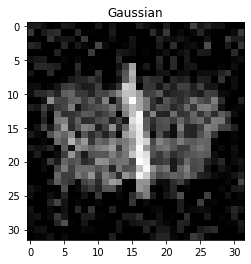

In [ ]:
print("example of image with noise: \n")
plt.title('Gaussian')
plt.imshow(add_noise(x_test_rob[0,:,:,0]), cmap='gray', interpolation='nearest')


In [ ]:
# adding noise to all testset
x_test_rob_noise = x_test_rob
for i in range(n_samples_test):
  x_test_rob_noise[i,:,:,0] = add_noise(x_test_rob[i,:,:,0])

In [ ]:
print(x_test_rob_noise.shape)

(20000, 32, 32, 1)


#### Evaluating the model on noise set

In [ ]:
MSE_rob = evaluate_model(unet_model, x_test_rob_noise,  y_test_rob, mse)
print("The mse on test with noise is: " + str(MSE_rob) + "\n")

The mse on test with noise is: 0.012925487



Example of the first sample predicted after noise



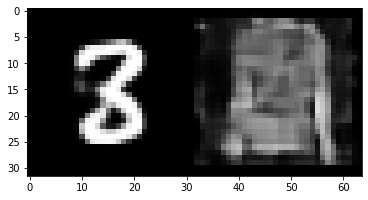

In [ ]:
print("Example of the first sample predicted after noise\n")

y_pred_noise = unet_model.predict(x_test_rob_noise)

plt.imshow(y_pred_noise[15,:,:,0], cmap='gray', interpolation='nearest')

The results are not so good at a first look, but we must say that the noise with respect to the quality of images is almost high. The mse value loses one figure of precision.
The numbers, which are simpler than other images, are separated in a pretty good way.

# Improving the result of previous network with another model

### Trying autoencoder in order to reach a better quality image, starting from the Unet model output.


The autoencoder are good in learning the latent space rapresentation and also in tasks of reconstruction of images.
They are used for example in denoising applications and for this reason they may help in achieve better mse.
Another important point is the nature of autoencoder, which take in input an image and return as output another one.

## In particular the structure used is an adversarial autoencoder.
### It is quite similar to an autoencoder but the encoder is trained in an adversarial manner to force it to output a required distribution.

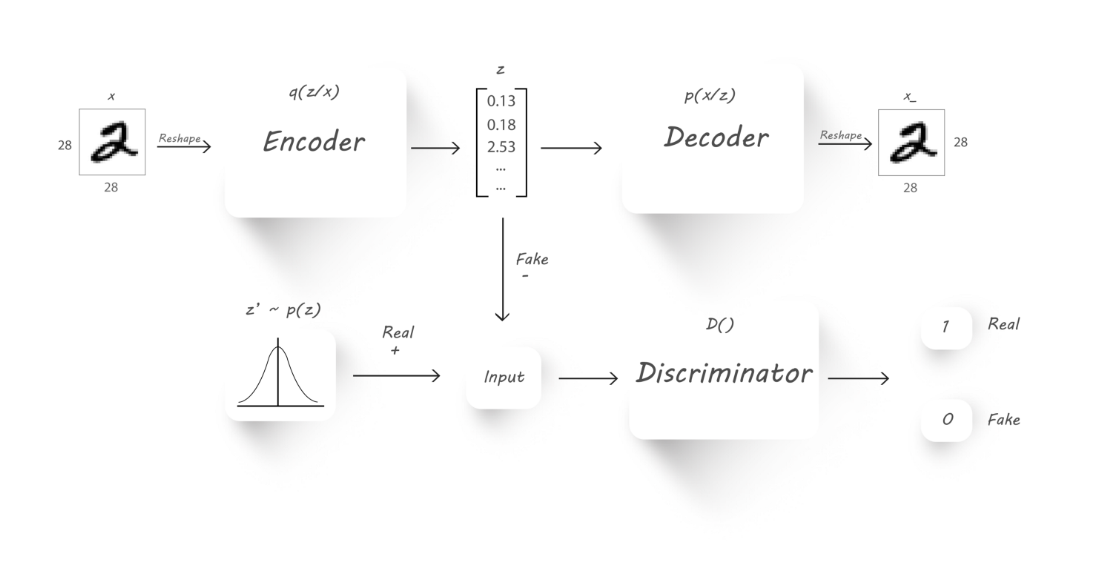

#### Creating training dataset from unet

In [ ]:
# set which is predicted by trained unet
x_aae = np.ndarray(shape=(n_samples_train, 32,32,1))
y_train_aae = np.ndarray(shape=(n_samples_train, 32,64,1))
x_train_aae = np.ndarray(shape=(n_samples_train, 32,64,1))

create_dataset(x_aae, y_train_aae, 1)

x_aae = x_aae.astype('float32')
y_train_aae = y_train_aae.astype('float32')

x_train_aae = unet_model.predict(x_aae)

example of dataset's image before reconstruction


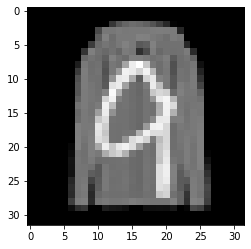

In [ ]:
print("example of dataset's image before reconstruction")
plt.imshow(x_aae[0,:,:,0], cmap='gray', interpolation='nearest')

example of dataset's image reconstructed by unet


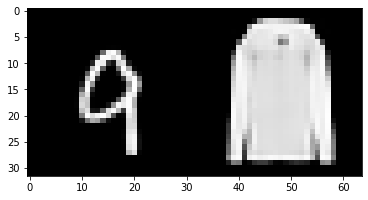

In [ ]:
print("example of dataset's image reconstructed by unet")
plt.imshow(x_train_aae[0,:,:,0], cmap='gray', interpolation='nearest')

final goal


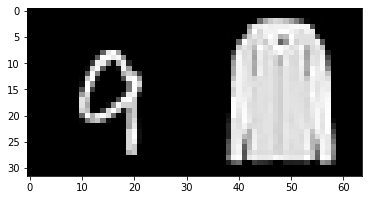

In [ ]:
print("final goal")
plt.imshow(y_train_aae[0,:,:,0], cmap='gray', interpolation='nearest')

## AAE model

In [ ]:
# Parameters
# loss = 'binary_crossentropy'
loss = 'mse'
batchsize = 64
epochnumber = 15

building encoder, decoder, discriminator

In [ ]:
def build_model_enc():
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(32, 64, 1)))
    model.add(Conv2D(64, (3,3), strides=(2,2), activation="relu", padding="same"))
    # model.add(Conv2D(128, (3,3), strides=(2,2), activation="relu", padding="same"))
    model.add(Flatten())
    model.add(Dense(2, activation="linear"))

    return model

def build_model_dec():
    model = keras.models.Sequential()
    model.add(Dense(8192, input_shape=(2,)))
    model.add(Reshape((8, 16, 64)))
    # model.add(Reshape((8, 16, 128)))
    model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
    model.add(UpSampling2D())
    model.add(Conv2D(32, (3,3), activation="relu", padding="same"))
    model.add(UpSampling2D())
    model.add(Conv2D(1, (3,3), activation="sigmoid", padding="same"))

    return model

def build_model_disc():
    model = keras.models.Sequential()
    model.add(Dense(32, activation="relu", input_shape=(2,)))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

Put together various part of the whole design, output = AAE structure

In [ ]:
def build_model_aae():
    model_enc = build_model_enc()
    model_dec = build_model_dec()
    model_disc = build_model_disc()

    model_ae = keras.models.Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)

    model_enc_disc = keras.models.Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)

    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

Model **summary**

In [ ]:
model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

model_disc.compile(optimizer=Adam(lr=1e-4), loss=loss)
model_enc_disc.compile(optimizer=Adam(lr=1e-4), loss=loss)
model_ae.compile(optimizer=Adam(lr=1e-3), loss=loss)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_296 (Conv2D)         (None, 32, 64, 32)        320       
                                                                 
 conv2d_297 (Conv2D)         (None, 16, 32, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 84,354
Trainable params: 84,354
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Some helper functions to facilitate training and give a nice overview of the 2 dimensional latent space are defined.



In [ ]:
def imagegrid(dec, epochnumber):
        fig = plt.figure(figsize=[20, 20])

        for i in range(-5, 5):
            for j in range(-5,5):
                topred = np.array((i*0.5,j*0.5))
                topred = topred.reshape((1, 2))
                img = dec.predict(topred)
                img = img.reshape((32, 64))
                ax = fig.add_subplot(10, 10, (i+5)*10+j+5+1)
                ax.set_axis_off()
                ax.imshow(img, cmap="gray")

        fig.savefig(str(epochnumber)+".png")
        plt.show()
        plt.close(fig)

def settrainable(model, toset):
    for layer in model.layers:
        layer.trainable = toset
    model.trainable = toset

In [ ]:
def train_aae():
  for epoch_n in range(epochnumber):
    # np.random.shuffle(x_train_aae)

    for i in range(int(len(x_train_aae) / batchsize)):
      settrainable(model_ae, True)
      settrainable(model_enc, True)
      settrainable(model_dec, True)

      batch = x_train_aae[i*batchsize:i*batchsize+batchsize]
      model_ae.train_on_batch(batch, batch)

      settrainable(model_disc, True)
      batchpred = model_enc.predict(batch)
      fakepred = np.random.standard_normal((batchsize,2))
      discbatch_x = np.concatenate([batchpred, fakepred])
      discbatch_y = np.concatenate([np.zeros(batchsize), np.ones(batchsize)])
      model_disc.train_on_batch(discbatch_x, discbatch_y)

      settrainable(model_enc_disc, True)
      settrainable(model_enc, True)
      settrainable(model_disc, False)
      model_enc_disc.train_on_batch(batch, np.ones(batchsize))

  print ("Reconstruction Loss:", model_ae.evaluate(x_train_aae, x_train_aae, verbose=0))
  print ("Adverserial Loss:", model_enc_disc.evaluate(x_train_aae, np.ones(len(x_train_aae)), verbose=0))


  # imagegrid(model_dec, epochnumber)

## Training

In [ ]:
print("Training the model...")
train_aae()
print("Done!")

Training the model...
Reconstruction Loss: 0.0351070761680603
Adverserial Loss: 0.1155104860663414
Done!


Evaluate mse with new model on same testset

In [ ]:
# A new version of testset evaluation with 2 models

def evaluate_combination_model(model, model2, x, y, fun):
    y_pred1 = model.predict(x)
    y_pred2 = model2.predict(y_pred1)

    plt.imshow(y_pred2[0,:,:,0], cmap='gray', interpolation='nearest')

    y = np.expand_dims(y, -1)

    y_pred2 = y_pred.astype('float32')
    y = y.astype('float32')


    return fun(y, y_pred2)

0.13220632

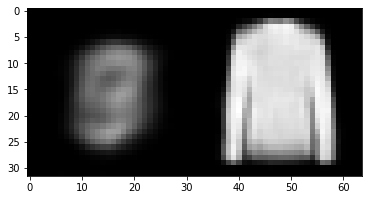

In [ ]:
evaluate_combination_model(unet_model, model_ae, x_test, y_test, mse)

## The second architecture doesn't improve quality looking to mse metric. So, it's better to keep only unet working alone, with an mse around 0.002X

### I thought it was a good idea trying to improve details with a generative model, probably I made something wrong in the net, or it is an incompatible structure for small images like this.

-------------------------------

---------------------

----------------------------------

# VAE has been tried but not uploaded in the notbook, result were not so good. This idea is used in next model with Unet

# Model number 2 (different approach): separate the extraction of the two components

Idea: train 2 network with same architecture, one in extracting images from first dataset, the other from the second. Give the summation image to both and concatenate the results in a doubled matrix.

Choosen architecture: VAE

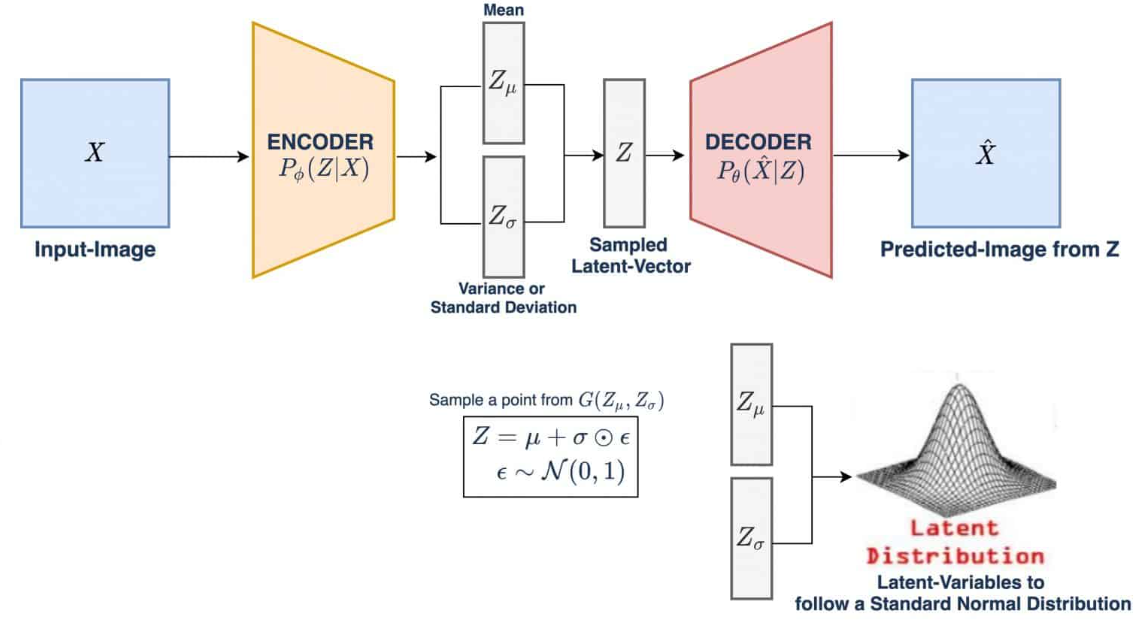

-----------

-------------

------------

# Model number 3: same approach of number 2 (the one not uploaded), but the choosen architecture are Unets

### Create the model

In [ ]:
input_shape = (32,32,1)
encoded_size = 16
base_depth = 64

#### Redefining generator 'return' in order to obtain the two components, not only summation and concatenation, it's like to split in two parts the concatenation image returned from original generator, it's just more convenient to do in that way

In [ ]:
def datagenerator_update(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)
        yield x_data, y_data, x1[num1], x2[num2]

In [ ]:
train_generator_update = datagenerator_update(mnist_x_train,fashion_mnist_x_train,1)
test_generator_update = datagenerator_update(mnist_x_test,fashion_mnist_x_test,1)
validation_generator_update = datagenerator_update(mnist_x_test,fashion_mnist_x_test,1)

In [ ]:
def create_sample_update(type):
    generator = train_generator_update
    if type==2:
        generator = test_generator_update
    if type==3:
        generator = validation_generator_update
    x, y, x1, x2 = next(generator)
    return (x, y, x1, x2)

def create_dataset_update(x, y, x1, x2, type):
    x_actual = np.ndarray(inputShape)
    y_actual = np.ndarray((32,64,1))
    x1_actual = np.ndarray(inputShape)
    x2_actual = np.ndarray(inputShape)


    samples = n_samples_train
    if type==2:
        samples = n_samples_test
    if type==3:
        samples = n_samples_test

    for i in range(samples):
        x_actual, y_actual, x1_actual, x2_actual = create_sample_update(type)

        x_t = K.permute_dimensions(x_actual, (1,2,0))
        y_t = K.permute_dimensions(y_actual, (1,2,0))
        x1_t = K.permute_dimensions(x1_actual, (1,2,0))
        x2_t = K.permute_dimensions(x2_actual, (1,2,0))
        x[i]= x_t
        y[i] = y_t
        x1[i]= x1_t
        x2[i] = x2_t

In [ ]:
x_train_up = np.ndarray(shape=(n_samples_train, 32,32,1))
y_train_up = np.ndarray(shape=(n_samples_train, 32,64,1))
x1_train_up = np.ndarray(shape=(n_samples_train, 32,32,1))
x2_train_up = np.ndarray(shape=(n_samples_train, 32,32,1))

create_dataset_update(x_train_up, y_train_up, x1_train_up, x2_train_up, 1)

# Reduce the amount of memory needed during learning
x_train_up = x_train_up.astype('float32')
y_train_up = y_train_up.astype('float32')
x1_train_up = x1_train_up.astype('float32')
x2_train_up = x2_train_up.astype('float32')

print(x_train_up.shape)
print(y_train_up.shape)
print(x1_train_up.shape)
print(x2_train_up.shape)

(100000, 32, 32, 1)
(100000, 32, 64, 1)
(100000, 32, 32, 1)
(100000, 32, 32, 1)


In [ ]:
x_test_up = np.ndarray(shape=(n_samples_test, 32,32,1))
y_test_up = np.ndarray(shape=(n_samples_test, 32,64,1))

x1_test_up = np.ndarray(shape=(n_samples_test, 32,32,1))
x2_test_up = np.ndarray(shape=(n_samples_test, 32,32,1))

create_dataset_update(x_test_up, y_test_up, x1_test_up, x2_test_up, 2)

x_test_up = x_test_up.astype('float32')
y_test_up = y_test_up.astype('float32')
x1_test_up = x1_test_up.astype('float32')
x2_test_up = x2_test_up.astype('float32')

print(x_test_up.shape)
print(y_test_up.shape)
print(x1_test_up.shape)
print(x2_test_up.shape)

(20000, 32, 32, 1)
(20000, 32, 64, 1)
(20000, 32, 32, 1)
(20000, 32, 32, 1)


In [ ]:
x_val_up = np.ndarray(shape=(n_samples_val, 32,32,1))
y_val_up = np.ndarray(shape=(n_samples_val, 32,64,1))

x1_val_up = np.ndarray(shape=(n_samples_val, 32,32,1))
x2_val_up = np.ndarray(shape=(n_samples_val, 32,32,1))

create_dataset_update(x_val_up, y_val_up, x1_val_up, x2_val_up, 3)

x_val_up = x_val_up.astype('float32')
y_val_up = y_val_up.astype('float32')
x1_val_up = x1_val_up.astype('float32')
x2_val_up = x2_val_up.astype('float32')

print(x_val_up.shape)
print(y_val_up.shape)
print(x1_val_up.shape)
print(x2_val_up.shape)

(20000, 32, 32, 1)
(20000, 32, 64, 1)
(20000, 32, 32, 1)
(20000, 32, 32, 1)


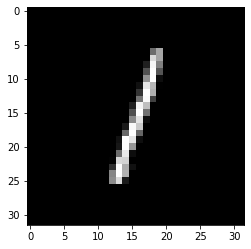

In [ ]:
plt.imshow(x1_train_up[0,:,:,0], cmap='gray', interpolation='nearest')

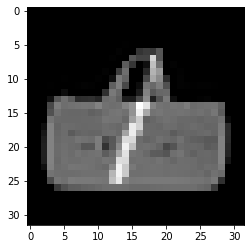

In [ ]:
plt.imshow(x_train_up[0,:,:,0], cmap='gray', interpolation='nearest')

#### Create the model and training

In [ ]:
lr = 1e-3

loss = 'binary_crossentropy'
optimizer = keras.optimizers.Adam(learning_rate=lr)
metric = ['mse']

In [ ]:
epochs = 10
batchsize = 64
inputShape = (32,32,1)

First part of architecture

In [ ]:
# model for extraction of number
def create_model_first(inputShape, n_ch=32, L=5, conv_per_L=2):
    x = Input(shape=inputShape)

    # pad_layer = ZeroPadding2D(padding=((0,0),(16,16)))(x)

    backup_layers = []
    h = x

    for l in range(L):
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1:
            # Downsample
            backup_layers.append(h)
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2

    for l in range(L-1):
        n_ch = n_ch // 2

        # Upsample
        h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

    # Output
    y = Conv2D(1, 1, activation='sigmoid')(h)
    return Model(x, y)

unet_model_first = create_model_first(inputShape)

unet_model_first.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metric)

print(unet_model_first.summary())

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_301 (Conv2D)            (None, 32, 32, 32)   320         ['input_22[0][0]']               
                                                                                                  
 re_lu_265 (ReLU)               (None, 32, 32, 32)   0           ['conv2d_301[0][0]']             
                                                                                                  
 conv2d_302 (Conv2D)            (None, 32, 32, 32)   9248        ['re_lu_265[0][0]']              
                                                                                           

In [ ]:
history_first = unet_model_first.fit(x_train_up, x1_train_up,
              batch_size=batchsize,
              epochs=epochs,
              validation_data=[x_val_up, x1_val_up]
            )

Epoch 1/10
1563/1563 [==============================] - 39s 24ms/step - loss: 0.0693 - mse: 0.0069 - val_loss: 0.0528 - val_mse: 0.0019
Epoch 2/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0516 - mse: 0.0016 - val_loss: 0.0504 - val_mse: 0.0013
Epoch 3/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0501 - mse: 0.0012 - val_loss: 0.0496 - val_mse: 0.0011
Epoch 4/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0493 - mse: 0.0010 - val_loss: 0.0493 - val_mse: 0.0011
Epoch 5/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0488 - mse: 9.3043e-04 - val_loss: 0.0488 - val_mse: 9.6043e-04
Epoch 6/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0485 - mse: 8.5958e-04 - val_loss: 0.0483 - val_mse: 8.4305e-04
Epoch 7/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0486 - mse: 8.9103e-04 - val_loss: 0.0486 - val_mse: 9.1948e-04
Epoch 8/10
1563/1563 [==

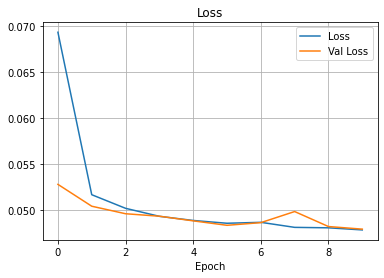

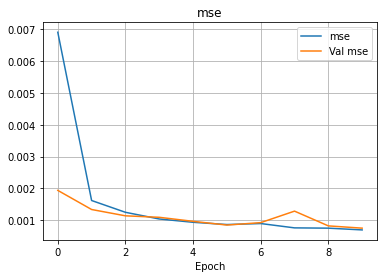

In [ ]:
# Check overfit
loss_history = history_first.history['loss']
val_loss_history = history_first.history['val_loss']

mse_history = history_first.history['mse']
val_mse_history = history_first.history['val_mse']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(mse_history)
plt.plot(val_mse_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mse', 'Val mse'])
plt.title('mse')
plt.show()

Original input:


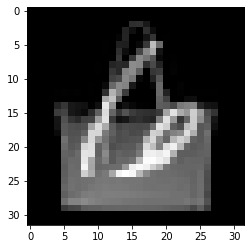

In [ ]:
prediction1 = unet_model_first.predict(x_test_up)
print('Original input:')
plt.imshow(x_test_up[0,:,:,0], cmap='gray', interpolation='nearest')

Goal:


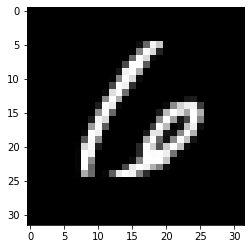

In [ ]:
print('Goal:')
plt.imshow(x1_test_up[0,:,:,0], cmap='gray', interpolation='nearest')

Reconstruction:

 mse: 
0.0007523713


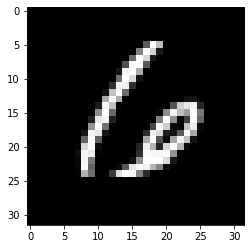

In [ ]:
print('Reconstruction:')
plt.imshow(prediction1[0,:,:,0], cmap='gray', interpolation='nearest')

print("\n mse: ")
MSE = evaluate_model(unet_model_first, x_test_up,  x1_test_up, mse)
print(MSE)

Second part of architecture

In [ ]:
# model for extraction of fashion_mnist elements
def create_model_second(inputShape, n_ch=32, L=4, conv_per_L=2):
    x = Input(shape=inputShape)

    # pad_layer = ZeroPadding2D(padding=((0,0),(16,16)))(x)

    backup_layers = []
    h = x

    for l in range(L):
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5))(h)
            h = ReLU()(h)

        if l < L-1:
            # Downsample
            backup_layers.append(h)
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2

    for l in range(L-1):
        n_ch = n_ch // 2

        # Upsample
        h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5))(h)
            h = ReLU()(h)

    # Output
    y = Conv2D(1, 1, activation='sigmoid')(h)
    return Model(x, y)

unet_model_second = create_model_second(inputShape)

unet_model_second.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metric)

print(unet_model_second.summary())

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_320 (Conv2D)            (None, 32, 32, 32)   320         ['input_23[0][0]']               
                                                                                                  
 re_lu_283 (ReLU)               (None, 32, 32, 32)   0           ['conv2d_320[0][0]']             
                                                                                                  
 conv2d_321 (Conv2D)            (None, 32, 32, 32)   9248        ['re_lu_283[0][0]']              
                                                                                           

In [ ]:
history_second = unet_model_second.fit(x_train_up, x2_train_up,
              batch_size=batchsize,
              epochs=epochs,
              validation_data=[x_val_up, x1_val_up]
            )

Epoch 1/10
1563/1563 [==============================] - 36s 21ms/step - loss: 267.5742 - mse: 0.0343 - val_loss: 0.6985 - val_mse: 0.1002
Epoch 2/10
1563/1563 [==============================] - 32s 21ms/step - loss: 1.2473 - mse: 0.0200 - val_loss: 0.7945 - val_mse: 0.1003
Epoch 3/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.6428 - mse: 0.0112 - val_loss: 0.7193 - val_mse: 0.1146
Epoch 4/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.5572 - mse: 0.0075 - val_loss: 0.7016 - val_mse: 0.1223
Epoch 5/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.5683 - mse: 0.0088 - val_loss: 0.6653 - val_mse: 0.1168
Epoch 6/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.4965 - mse: 0.0064 - val_loss: 0.6550 - val_mse: 0.1238
Epoch 7/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.4557 - mse: 0.0048 - val_loss: 0.6597 - val_mse: 0.1345
Epoch 8/10
1563/1563 [========================

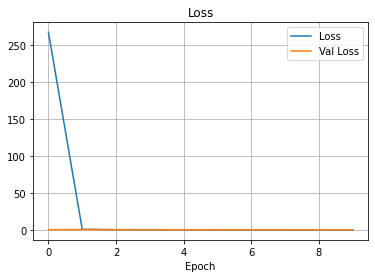

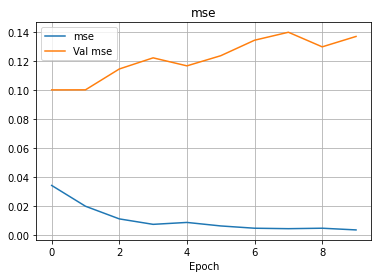

In [ ]:
# Check overfit
loss_history = history_second.history['loss']
val_loss_history = history_second.history['val_loss']

mse_history = history_second.history['mse']
val_mse_history = history_second.history['val_mse']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(mse_history)
plt.plot(val_mse_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mse', 'Val mse'])
plt.title('mse')
plt.show()

I'm not able to reduce overfitting even if I use regularizer or dropout layer for generating second image.

Original input:


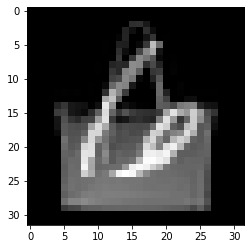

In [ ]:
prediction2 = unet_model_second.predict(x_test_up)
print('Original input:')
plt.imshow(x_test_up[0,:,:,0], cmap='gray', interpolation='nearest')

Goal:


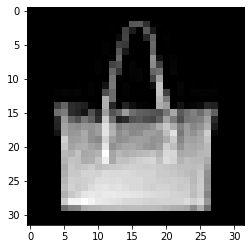

In [ ]:
print('Goal:')
plt.imshow(x2_test_up[0,:,:,0], cmap='gray', interpolation='nearest')

Reconstruction:

 mse: 
0.0033098343


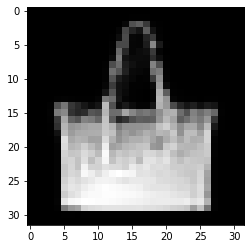

In [ ]:
print('Reconstruction:')
plt.imshow(prediction2[0,:,:,0], cmap='gray', interpolation='nearest')

print("\n mse: ")
MSE = evaluate_model(unet_model_second, x_test_up,  x2_test_up, mse)
print(MSE)

Construction of final results (concatenation)

In [ ]:
# exploit the 2 trained network for reconstructing final output (32,64,1) images

def reconstruct_output_final(x_test):
  pred_first = unet_model_first.predict(x_test)
  pred_second = unet_model_second.predict(x_test)

  final_output = np.ndarray(shape=(n_samples_test, 32,64,1))

  for i in range(n_samples_test):
    final_output[i,:,:,0] = np.concatenate((pred_first[i,:,:,0], pred_second[i,:,:,0]), axis=1)

  return final_output


In [ ]:
prediction_final = reconstruct_output_final(x_test_up)
print(prediction_final.shape)

(20000, 32, 64, 1)


Original: 


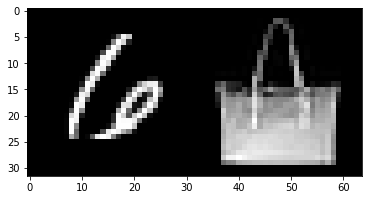

In [ ]:
print("Original: ")
plt.imshow(y_test_up[0,:,:,0], cmap='gray', interpolation='nearest')

Final reconstruction: 


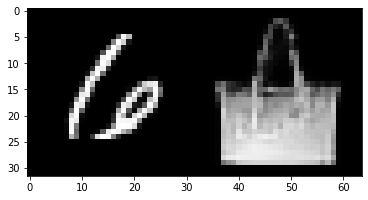

In [ ]:
print("Final reconstruction: ")
plt.imshow(prediction_final[0,:,:,0], cmap='gray', interpolation='nearest')

Printing results evaluation

In [ ]:
# compute the standard deviation over 10 mse
def standard_deviation_mse_update():
    MSE_results = []

    for i in range(10):
        x_test_local = np.ndarray(shape=(n_samples_test, 32,32,1))
        y_test_local = np.ndarray(shape=(n_samples_test, 32,64,1))
        create_dataset(x_test_local, y_test_local, 2)

        y_predicted = reconstruct_output_final(x_test_local)

        MSE_results.append(mse(y_test_local, y_predicted))

    std = np.std(MSE_results)

    return std, MSE_results

In [ ]:
std, mse_res = standard_deviation_mse_update()

print("The std is: {}\n".format(std))
print("The mse results are: \n{}".format(mse_res))

The std is: 9.353091627417598e-06

The mse results are: 
[0.0019993226, 0.0020132693, 0.0020050218, 0.0019971482, 0.0020082348, 0.0019799953, 0.002007795, 0.0020024718, 0.0019911143, 0.0019927965]


-------------------

---------------------------

-----------------------------

# Revisiting of the idea of first model. In this case there is a final concatenation from 2 conv layers of (32,32) dimensions, instead of initial padding to (32,64) as before in the previous one.

## It seems to have better performances even if it contains less parameters to train

In [ ]:
def create_model_singlepassage(inputShape, n_ch=64, L=2, conv_per_L=3):
  x = Input(shape=inputShape)

  backup_layers = []
  h = x

  for l in range(L):
      for c in range(conv_per_L):
          h = Conv2D(n_ch, 4, 1, padding='same')(h)
          h = ReLU()(h)

      if l < L-1:
          # Downsample
          backup_layers.append(h)
          h = MaxPool2D(padding='same')(h)

          # Update the channels
          n_ch = n_ch * 2

  for l in range(L-1):
      n_ch = n_ch // 2

      # Upsample
      h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

      # Concatenate
      h = concatenate([h, backup_layers.pop(-1)])

      # Each floor in the up phase
      for c in range(conv_per_L):
          h = Conv2D(n_ch, 4, 1, padding='same')(h)
          h = ReLU()(h)

  # Output
  y1 = Conv2D(1, 1, activation='sigmoid')(h)
  y2 = Conv2D(1, 1, activation='sigmoid')(h)

  output = concatenate([y1,y2], axis=2)
  return Model(x, output)

unet_model_singlepassage = create_model_singlepassage(inputShape)

unet_model_singlepassage.compile(optimizer=optimizer,
                loss=loss,
                metrics=metric)

print(unet_model_singlepassage.summary())

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_398 (Conv2D)            (None, 32, 32, 64)   1088        ['input_30[0][0]']               
                                                                                                  
 re_lu_348 (ReLU)               (None, 32, 32, 64)   0           ['conv2d_398[0][0]']             
                                                                                                  
 conv2d_399 (Conv2D)            (None, 32, 32, 64)   65600       ['re_lu_348[0][0]']              
                                                                                           

In [ ]:
# run 2 time
history_singlepassage = unet_model_singlepassage.fit(x_train, y_train,
              batch_size=batchsize,
              epochs=25,
              validation_data=[x_val, y_val]
            )

Epoch 1/25
1563/1563 [==============================] - 84s 53ms/step - loss: 0.1171 - mse: 7.2795e-04 - val_loss: 0.1181 - val_mse: 7.3603e-04
Epoch 2/25
1563/1563 [==============================] - 84s 54ms/step - loss: 0.1170 - mse: 7.1085e-04 - val_loss: 0.1181 - val_mse: 7.3754e-04
Epoch 3/25
1563/1563 [==============================] - 84s 54ms/step - loss: 0.1171 - mse: 7.4230e-04 - val_loss: 0.1181 - val_mse: 7.5379e-04
Epoch 4/25
1563/1563 [==============================] - 84s 53ms/step - loss: 0.1170 - mse: 6.9824e-04 - val_loss: 0.1182 - val_mse: 7.6116e-04
Epoch 5/25
1563/1563 [==============================] - 84s 53ms/step - loss: 0.1170 - mse: 7.0710e-04 - val_loss: 0.1193 - val_mse: 0.0011
Epoch 6/25
1563/1563 [==============================] - 84s 53ms/step - loss: 0.1169 - mse: 6.9341e-04 - val_loss: 0.1180 - val_mse: 7.1651e-04
Epoch 7/25
1563/1563 [==============================] - 83s 53ms/step - loss: 0.1169 - mse: 6.7501e-04 - val_loss: 0.1180 - val_mse: 7.2648e

In [ ]:
p_last = unet_model_singlepassage.predict(x_test)


Goal: 


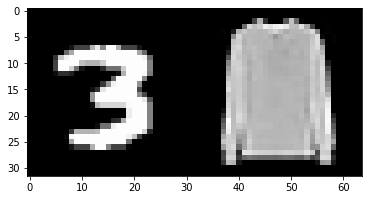

In [ ]:
print("Goal: ")
plt.imshow(y_test[0,:,:,0], cmap='gray', interpolation='nearest')

Reconstruction: 


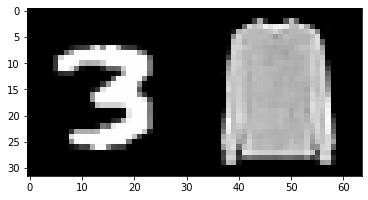

In [ ]:
print("Reconstruction: ")
plt.imshow(p_last[0,:,:,0], cmap='gray', interpolation='nearest')

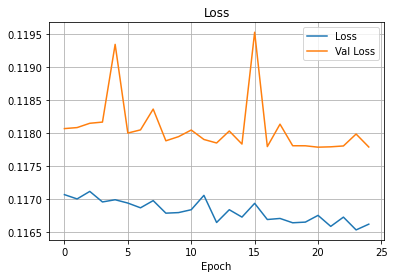

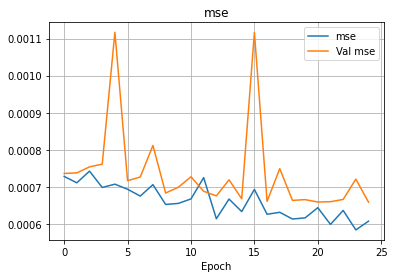

In [ ]:
# Check overfit
loss_history = history_singlepassage.history['loss']
val_loss_history = history_singlepassage.history['val_loss']

mse_history = history_singlepassage.history['mse']
val_mse_history = history_singlepassage.history['val_mse']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(mse_history)
plt.plot(val_mse_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mse', 'Val mse'])
plt.title('mse')
plt.show()

a small distance in  plot due to the fact that are very low numbers and a small overfitting

for this reason the net is better in separating images with respect to first model (more right pixel and details, also in test set), but made some confusion with this type of noise, not positional or rotation, instead it's some kinds of salt effect.

predict above noise image 



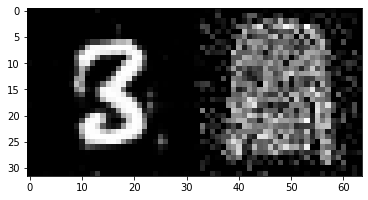

In [ ]:
print("predict above noise image \n")

y_pred_noise = unet_model_singlepassage.predict(x_test_rob_noise)

plt.imshow(y_pred_noise[15,:,:,0], cmap='gray', interpolation='nearest')

real one:


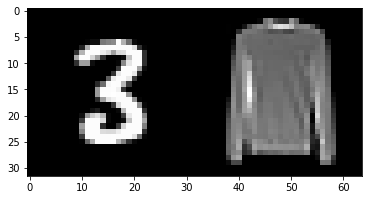

In [ ]:
print("real one:")
plt.imshow(y_test_rob[15,:,:,0], cmap='gray', interpolation='nearest')

In [ ]:
std, MSE_results = standard_deviation_mse(unet_model_singlepassage)
print("The std for Unet is: {}\n".format(std))
print("The mse results are: \n{}".format(MSE_results))

The std for Unet is: 3.7221361708361655e-06

The mse results are: 
[0.00066435424, 0.00067106826, 0.0006615297, 0.00066372845, 0.00066900713, 0.00066856446, 0.00067503465, 0.00066519727, 0.0006675859, 0.00066640566]


the mse results confirm that there is not so much overfitting, results are good

--------------------

# Results


### The results are almost similar. The last net perform a bit better than other. Unfortunatly I could not do other experiments ('cause of time) on adversarial autoencoder, I think it could be the best score. In the second model the problem is the recognizing the second image, with the first the resutls are brilliant, instead in second dataset there is overfitting.
